In [1]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from pmdarima import auto_arima

In [2]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [4]:
# Calcular los indices en los que el last_performance cambia
def calculate_change_indices(df):
    change_indices = []
    for i in range(1, len(df)):
        if df.iloc[i]['last_performance'] != df.iloc[i-1]['last_performance']:
            change_indices.append(i)
    return change_indices

calculate_change_indices(df[df['Player'] == 'Griezmann'])

[6,
 14,
 33,
 36,
 41,
 45,
 48,
 51,
 55,
 68,
 72,
 76,
 81,
 85,
 90,
 103,
 106,
 111,
 118,
 121,
 124,
 127,
 131,
 142,
 161,
 167,
 170,
 174,
 181,
 190,
 212,
 216,
 231,
 240,
 243,
 246,
 251,
 257,
 272,
 275,
 279,
 285,
 308,
 312,
 316]

In [89]:
def plot_results(y, df_jugador, df_predictions):
    match_indices = calculate_change_indices(df_jugador)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_jugador['Fecha'], df_jugador[y], label='Real', color='blue')
    plt.plot(df_predictions[df_predictions['Predicciones'].notnull()]['Fecha'], df_predictions[df_predictions['Predicciones'].notnull()]['Predicciones'], label='Predicción', color='red')
    plt.scatter(df_jugador.iloc[np.array(match_indices) - 1]['Fecha'], df_jugador.iloc[np.array(match_indices) - 1][y], color='green', label='Día antes de predicción')
    plt.title(f'Predicción de {y} para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)

    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_errors(df_jugador, df_predictions, y):
    aux = df_predictions[df_predictions['Predicciones'].notnull()]
    aux['Diferencia'] = abs(aux[y] - aux['Predicciones'])

    mean_error_todos = np.mean(aux['Diferencia'])
    std_error_todos = np.std(aux['Diferencia'])
    min_error_todos = np.min(aux['Diferencia'])
    max_error_todos = np.max(aux['Diferencia'])
    median_todos = np.median(aux['Diferencia'])

    change_indices = calculate_change_indices(df_jugador)

    match_days = df_jugador.iloc[np.array(change_indices)]['Fecha']
    errors_match_days = aux[aux['Fecha'].isin(match_days)]['Diferencia']

    mean_error_dia_partido = np.mean(errors_match_days)
    std_error_dia_partido = np.std(errors_match_days)
    min_error_dia_partido = np.min(errors_match_days)
    max_error_dia_partido = np.max(errors_match_days)
    median_dia_partido = np.median(errors_match_days)


    before_match_days = df_jugador.iloc[np.array(change_indices) - 1]['Fecha']
    errors_before_match_days = aux[aux['Fecha'].isin(before_match_days)]['Diferencia']

    mean_error_dia_antes_partido = np.mean(errors_before_match_days)
    std_error_dia_antes_partido = np.std(errors_before_match_days)
    min_error_dia_antes_partido = np.min(errors_before_match_days)
    max_error_dia_antes_partido = np.max(errors_before_match_days)
    median_dia_antes_partido = np.median(errors_before_match_days)

    print("______Todos los días____________")
    print(f"Mean error todos: {mean_error_todos}")
    print(f"Std error todos: {std_error_todos}")
    print(f"Min error todos: {min_error_todos}")
    print(f"Max error todos: {max_error_todos}")
    print(f"Median error todos: {median_todos}\n")

    print("______Días de partido___________")
    print(f"Mean error dia partido: {mean_error_dia_partido}")
    print(f"Std error dia partido: {std_error_dia_partido}")
    print(f"Min error dia partido: {min_error_dia_partido}")
    print(f"Max error dia partido: {max_error_dia_partido}")
    print(f"Median error dia partido: {median_dia_partido}\n")

    print("______Días antes de partido_____")
    print(f"Mean error dia antes partido: {mean_error_dia_antes_partido}")
    print(f"Std error dia antes partido: {std_error_dia_antes_partido}")
    print(f"Min error dia antes partido: {min_error_dia_antes_partido}")
    print(f"Max error dia antes partido: {max_error_dia_antes_partido}")
    print(f"Median error dia antes partido: {median_dia_antes_partido}")

In [90]:
def evaluate_model(df_jugador, order, seasonal_order, y, exog, options):
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    match_indices = calculate_change_indices(df_jugador)

    for i in range(len(match_indices)-1):
        matchday = match_indices[i]
        next_matchday = match_indices[i+1]

        train_data = df_jugador.iloc[:matchday]
        test_data = df_jugador.iloc[matchday:]
        
        days_to_next_match = next_matchday - matchday
        
        modelo = SARIMAX(train_data[y], 
                            exog=train_data[exog],
                            order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()
        
        if options == 'next_match':
            predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                            exog=test_data[exog][:days_to_next_match], dynamic=False)
            
            df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

        elif options == 'next_day':
            # Solo se predice un día
            predicciones = resultado.predict(start=matchday, end=matchday,
                                            exog=test_data[exog][:1], dynamic=False)
        
            df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

    
    if options == 'next_day':        
        # Rellenar los valores nulos con el último valor conocido
        df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
    
    plot_results(y, df_jugador, df_predictions)
    calculate_errors(df_jugador, df_predictions, y)

    return df_predictions

def evaluate_model_no_exog(df_jugador, order, seasonal_order, y, options):
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    match_indices = calculate_change_indices(df_jugador)

    for i in range(len(match_indices)-1):
        matchday = match_indices[i]
        next_matchday = match_indices[i+1]

        train_data = df_jugador.iloc[:matchday]
        
        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()
        
        if options == 'next_match':
            predicciones = resultado.predict(start=matchday, end=next_matchday-1, dynamic=False)
            
            df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

        elif options == 'next_day':
            # Solo se predice un día
            predicciones = resultado.predict(start=matchday, end=matchday, dynamic=False)
        
            df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

    
    if options == 'next_day':        
        # Rellenar los valores nulos con el último valor conocido
        df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
    
    plot_results(y, df_jugador, df_predictions)
    calculate_errors(df_jugador, df_predictions, y)

    return df_predictions

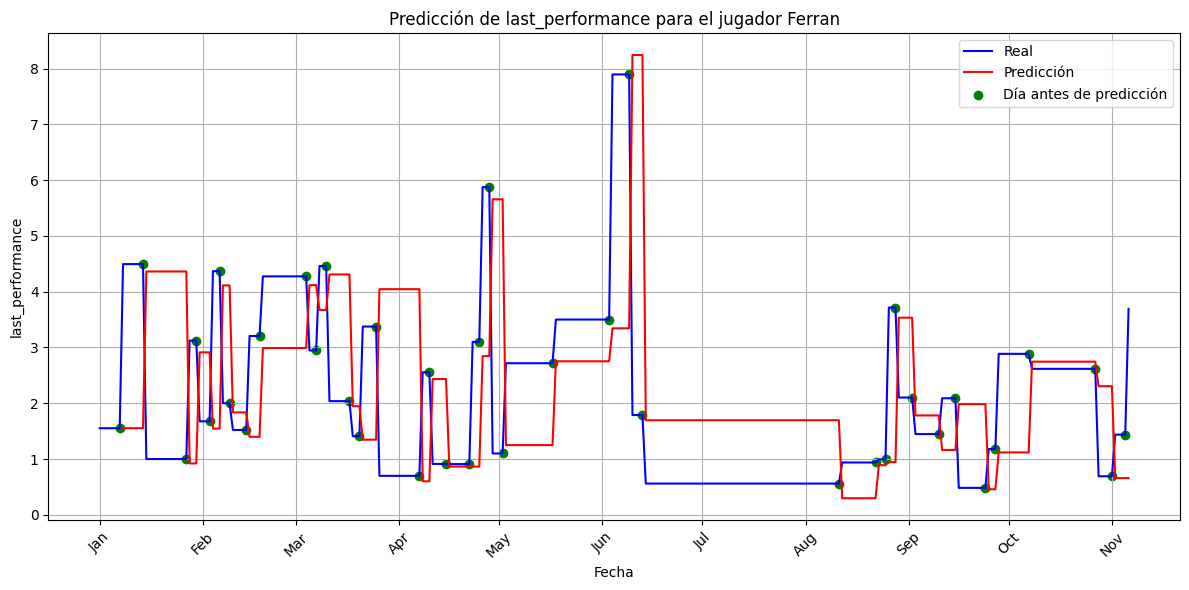

______Todos los días____________
Mean error todos: 1.5758725500403195
Std error todos: 1.2018492689988782
Min error todos: 0.04376008584272184
Max error todos: 6.455519761292287
Median error todos: 1.236675660245322

______Días de partido___________
Mean error dia partido: 1.8383010573365777
Std error dia partido: 1.356024100346534
Min error dia partido: 0.04376008584272184
Max error dia partido: 6.455519761292287
Median error dia partido: 1.5226803226025523

______Días antes de partido_____
Mean error dia antes partido: 1.8068032213905105
Std error dia antes partido: 1.3595949533265952
Min error dia antes partido: 0.04376008584272184
Max error dia antes partido: 6.455519761292287
Median error dia antes partido: 1.512020048838162


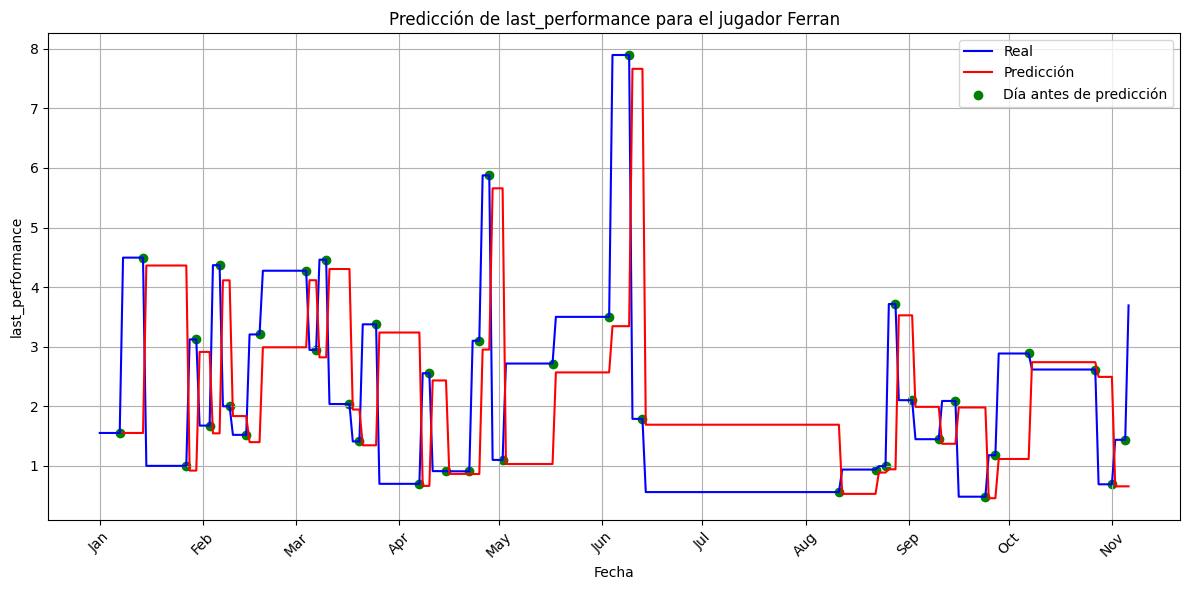

______Todos los días____________
Mean error todos: 1.5565997193875778
Std error todos: 1.125762149119646
Min error todos: 0.044080811387619434
Max error todos: 5.87479870966386
Median error todos: 1.236675660061736

______Días de partido___________
Mean error dia partido: 1.828800726374752
Std error dia partido: 1.2763875261086288
Min error dia partido: 0.044080811387619434
Max error dia partido: 5.87479870966386
Median error dia partido: 1.6862628106300395

______Días antes de partido_____
Mean error dia antes partido: 1.7970181938018606
Std error dia antes partido: 1.2777491292676761
Min error dia antes partido: 0.044080811387619434
Max error dia antes partido: 5.87479870966386
Median error dia antes partido: 1.6627272060956089


In [88]:
jugador = 'Ferran'
df_jugador = df[df['Player'] == jugador]
order = (1,0,0)
seasonal_order = (0,0,0,0)
y = 'last_performance'
# y = 'Noticias_negativas'
exog = 'Noticias_negativas'
# exog = 'last_performance'
df_predictions = evaluate_model(df_jugador, order, seasonal_order, y, exog, options='next_day')
df_predictions2 = evaluate_model_no_exog(df_jugador, order, seasonal_order, y, options='next_day')

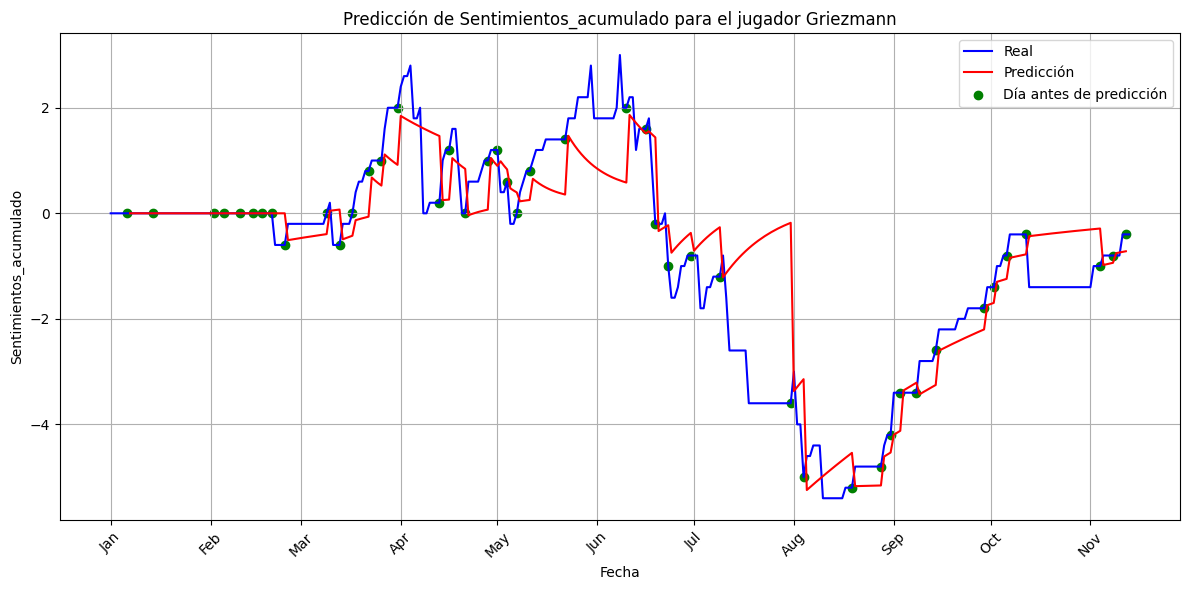

Mean error: 0.34705523421382706
Std error: 0.258914084099108
Min error: 8.797410913509593e-07
Max error: 0.9669516209358668
Median error: 0.3339910382973178
Performance maximas: 8.193127664910962
Performance minimas: 1.7050413844996235


In [62]:
jugador = 'Griezmann'
df_jugador = df[df['Player'] == jugador]
order = (1,0,1)
seasonal_order = (0,0,0,0)
# y = 'last_performance'
y = 'Sentimientos_acumulado'
exog = 'last_performance'
# exog = 'last_performance'
df_predictions = evaluate_model(df_jugador, order, seasonal_order, y, exog)

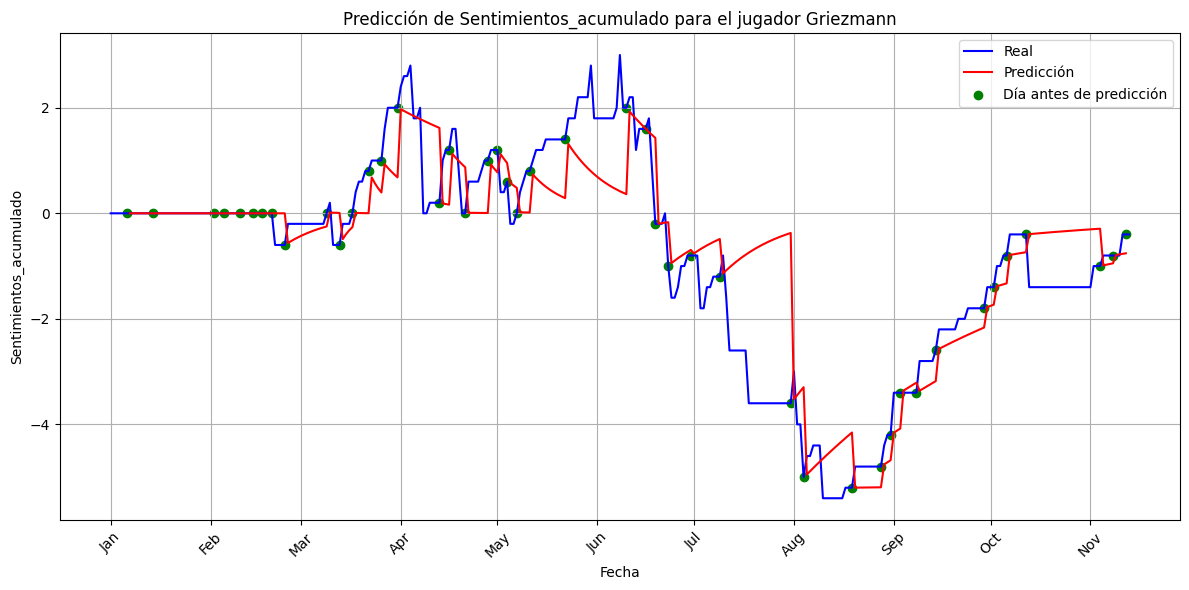

Mean error: 0.34821484560619
Std error: 0.2584811832588573
Min error: 0.0
Max error: 1.005451900065756
Median error: 0.3609412084244096
Performance maximas: 8.193127664910962
Performance minimas: 1.7050413844996235


,Fecha,Sentimientos_acumulado,Predicciones
591,2023-08-14,0.0,NaN
592,2023-08-15,0.0,NaN
593,2023-08-16,0.0,NaN
594,2023-08-17,0.0,NaN
595,2023-08-18,0.0,NaN
...,...,...,...
903,2024-06-21,-0.8,-0.789299
904,2024-06-22,-0.8,-0.778754
905,2024-06-23,-0.4,-0.768350
906,2024-06-24,-0.4,-0.758085


In [63]:
evaluate_model_no_exog(df_jugador, order, seasonal_order, y)